In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
def swiss_roll(N):
    """Generates a swiss roll dataset with N samples."""
    dataset = np.ndarray((N, 3))

    
    dataset[:, 1] = np.random.uniform(-6, 6, N)

    N_inv = 1 / N

    t = 8 * np.arange(N) * N_inv + 2

    dataset[:, 0] = t * np.sin(t)
    dataset[:, 2] = t * np.cos(t)

    return dataset

## Generate the dataset
Generate a N-samples swiss roll dataset, as a N $\times$ 3 matrix made as [x, y, z]

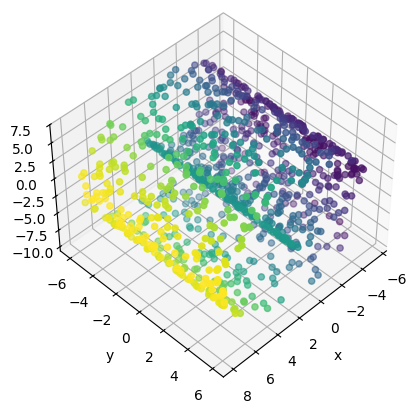

In [4]:
N_samples: int = 1000
X = swiss_roll(N_samples)

axes = plt.axes(projection='3d', aspect='auto', elev=45, azim=45)

axes.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c = X[:, 0], cmap='viridis')

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

plt.show()

### Step 1: KNN

Find the k nearest neighbors of each point, as a N_samples $\times$ n_neighbors list of distances and indexes

In [5]:
n_neighbors: int = 10
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean').fit(X)

distances, indexes = nbrs.kneighbors(X)

print("Distances:\n", distances[0:5, :])
print("\n")
print("Indexes:\n", indexes[0:5, :])

Distances:
 [[0.         0.27643071 0.56340369 0.69906192 0.7893289  0.83798604
  0.88459693 1.05481038 1.15235871 1.18531331]
 [0.         0.23352317 0.46904058 0.6167393  0.73045828 0.85830174
  1.00958563 1.1214812  1.1421031  1.15944594]
 [0.         0.16358485 0.3087576  0.57131327 0.65911715 0.77809185
  1.01697476 1.02371034 1.17105416 1.29713167]
 [0.         0.35401538 0.5170412  0.62920896 0.66008729 0.71868712
  0.8071842  0.83698197 0.88960317 0.94584878]
 [0.         0.16705502 0.20411632 0.53778883 0.66008729 0.66808808
  0.67789548 0.74619679 0.76309113 0.80316891]]


Indexes:
 [[ 0 14 25 16 40 10  8  7 12 28]
 [ 1  6 23 20 13 38 51 48 53 55]
 [ 2  5 11 32 21 35 30 49 46 42]
 [ 3 22 29 36  4 15  9 41 45 27]
 [ 4  9 15 18  3 39 29 41 22 43]]


### Step 2: Compute relationships between neighbors

1. Compute the euclidean distance $\delta_{ij}$ betwen each point $p_i$ and each neighbor $n_{i, j}$ (already done in the previous step)
2. For each point $p_i$ and each of its neighbors $n_{i, j}$, find the neighbor of $n_{i, j}$, $m_{ij}$, that is the most collinear (= forms an angle that is the closest to $\pi$) to $p_i$ and $n_{i, j}$ and calculate the angle $\theta_{i, j}$ between $(p_i,\,n_{i, j})$ and $(n_{i, j},\,m_{ij})$.
3. Represent this as a 3D numpy ndarray of shape N_points $\times$ n_neighbors $\times$ 2

In [6]:
def calculate_angle(p, n, m, dist_pn, dist_nm):
    """Calculates the angle between the vectors p-n and p-m.
        - p: coordinates of the point p
        - n: coordinates of the point n
        - m: coordinates of the point m
        - dist_pn: distance between p and n
        - dist_nm: distance between p and m
    """
    pn = n - p # vector from p to n
    nm = m - n # vector from n to m
    dot_prod = np.dot(pn, nm) # dot product of pn and nm
    norm_prod = dist_pn * dist_nm # product of the norms of pn and nm

    cos_theta = dot_prod / norm_prod # cosine of the angle between pn and nm

    return np.arccos(cos_theta)

In [20]:
def most_collinear_point_pn(dataset: np.ndarray, indexes: np.ndarray, distances: np.ndarray, idx_p: int, neighbor_number_n: int):
    """Finds the most collinear point to the line p-n.
        - dataset: dataset with the coordfinates of the points
        - indexes: indexes of the neighbors of each point
        - distances: distances between each point and its neighbors
        - idx_p: index of the point p
        - neighbor_number_n: index of the neighbor of p that defines the line p-n
    """

    n_neighbors: int = indexes.shape[1] # Number of neighbors of each point

    p = dataset[idx_p] # Coordinates of the point p
    idx_n: int = indexes[idx_p, neighbor_number_n] # Index of neighbor_number_n-th neighbor of p
    dist_pn = distances[idx_p, neighbor_number_n] # Distance between p and n
    n = dataset[idx_n] # Coordinates of the point n

    neighbors_n_idxs = indexes[idx_n, 1:] # Start from 1 to avoid n itself
    idx_p_in_n = np.where(neighbors_n_idxs == idx_p)
    neighbors_n_idxs = np.delete(neighbors_n_idxs, idx_p_in_n) # Remove p from the neighbors of n
    neighbor_number_m = np.arange(1, n_neighbors) # Index of the point m in the neighbors of n
    neighbor_number_m = np.delete(neighbor_number_m, idx_p_in_n) # Remove p from the indexes of the neighbors of n
    distances_n = distances[idx_n, neighbor_number_m] # Start from 1 to avoid n itself

    max_angle = 0 # Initialize the maximum angle between the vectors p-n and p-m
    idx_max_angle = -1 # Initialize the index of the point m that forms the maximum angle with p-n
    
    for i, idx_m in enumerate(neighbors_n_idxs):
        m = dataset[idx_m] # Coordinates of the point m
        dist_nm = distances_n[i] # Distance between n and m

        angle = calculate_angle(p, n, m, dist_pn, dist_nm) # Calculate the angle between the vectors p-n and p-m
        
        # Update the maximum angle and the index of the point m that forms the maximum angle with p-n
        if angle > max_angle:
            max_angle = angle
            idx_max_angle = idx_m
    
    return idx_max_angle, max_angle
most_collinear_point_pn(dataset=X, indexes=indexes, distances=distances, idx_p=0, neighbor_number_n=2)

(np.int64(14), np.float64(2.9392232931332303))

In [8]:
most_collinear_points = np.zeros((indexes.shape[0], indexes.shape[1]), dtype=int)
most_collinear_angles = np.zeros((indexes.shape[0], indexes.shape[1])) * np.nan

for idx_p, p in enumerate(X):
    for neighbor_number_n in range(1, n_neighbors):
        idx_m, angle = most_collinear_point_pn(dataset=X, indexes=indexes, distances=distances, idx_p=idx_p, neighbor_number_n=neighbor_number_n)
        most_collinear_points[idx_p, neighbor_number_n] = idx_m
        most_collinear_angles[idx_p, neighbor_number_n] = angle

    
most_collinear_points = most_collinear_points[:, 1:]
most_collinear_angles = most_collinear_angles[:, 1:]

In [9]:
print(most_collinear_points[0:5, :])
print()
print(most_collinear_angles[0:5, :])

[[ 8 14 14 14 14 14  8 14 14]
 [20  6  6  6 23 23 38 23 38]
 [21  5  5  5  5 21 32  5 21]
 [ 4 22 22 22 22 22 29 22 22]
 [ 3  9  9  9 15 15 15 15 15]]

[[2.07195378 2.93922329 2.7592166  2.84642476 2.84280782 2.86397513
  2.91674612 2.91445431 2.95584109]
 [2.39839823 2.67570145 2.88249816 3.09790138 2.56948274 2.94383566
  2.99603681 3.05332301 2.69005194]
 [2.40777024 2.90342385 2.85770196 2.974603   2.99979809 3.08497727
  2.59431832 3.06880031 3.05340464]
 [2.09819004 2.507401   2.89659865 2.65971672 2.645073   2.71864525
  2.84699032 2.9098326  2.76530841]
 [2.69931301 2.21850124 3.10623756 3.03306117 3.08657351 2.85590923
  2.9812054  2.87140939 3.04566682]]


In [10]:
# compute average distance between neighbors
avg_dist = np.mean(distances[:, 1:])
print(avg_dist)

0.9186756786189091


### Step 3
Optionally preprocess the data. The data may optionally be preprocessed with the transformation step of Principal Component Analysis (PCA), or another efficient algorithm. Manifold Sculpting will work without this step; however, preprocessing can result in significantly faster convergence. To the extent that there is a linear component in the manifold, PCA will move the information in the data into as few dimensions as possible, thus leaving less work to be done in step 4 (which handles the non-linear component). This step is performed by computing the first $|D_{pres}|$ principal components of the data (where $D_{pres}$ is the set of dimensions that will be preserved in the projection), and rotating the dimensional axes to align with these principal components.

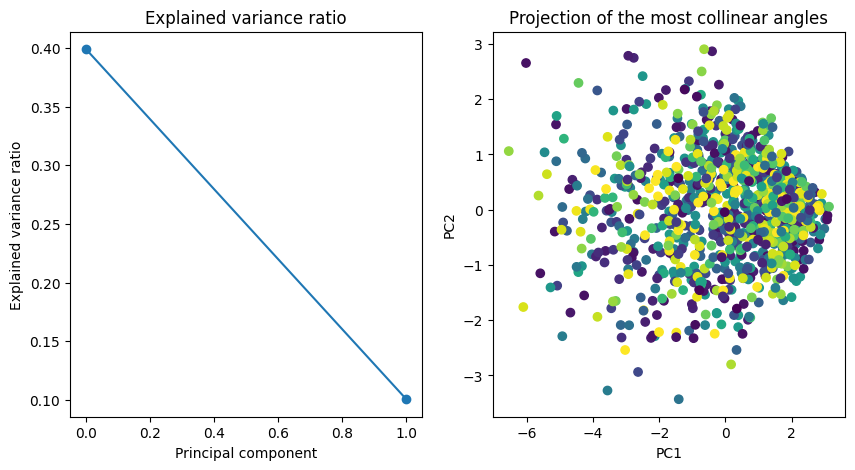

In [11]:
Dpres: int = 2
most_collinear_angles_norm = StandardScaler().fit_transform(most_collinear_angles)

pca = PCA(n_components=Dpres).fit(most_collinear_angles_norm)

mca_pca = pca.transform(most_collinear_angles_norm)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(pca.explained_variance_ratio_, marker='o')
axs[0].set_xlabel('Principal component')
axs[0].set_ylabel('Explained variance ratio')
axs[0].set_title('Explained variance ratio')

axs[1].scatter(mca_pca[:, 0], mca_pca[:, 1], c=X[:, 0])
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_title('Projection of the most collinear angles')
plt.show()

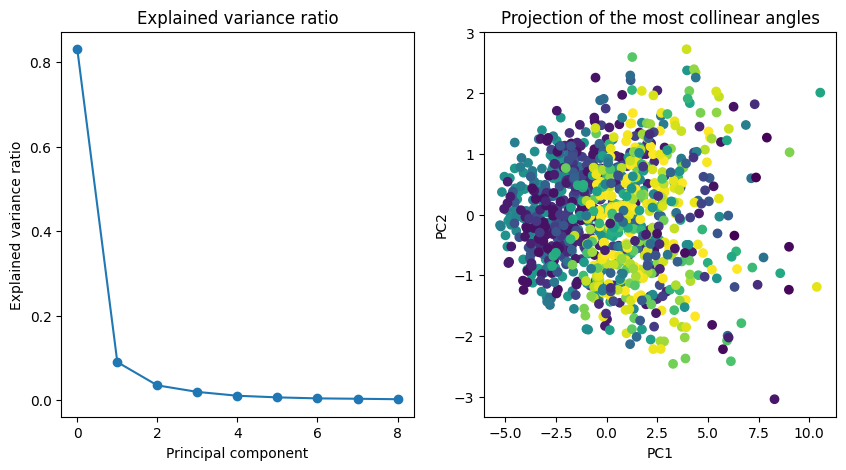

In [12]:
distances_norm = StandardScaler().fit_transform(distances[:, 1:])

pca = PCA(n_components=n_neighbors-1).fit(distances_norm)

dist_pca = pca.transform(distances_norm)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(pca.explained_variance_ratio_, marker='o')
axs[0].set_xlabel('Principal component')
axs[0].set_ylabel('Explained variance ratio')
axs[0].set_title('Explained variance ratio')

axs[1].scatter(dist_pca[:, 0], dist_pca[:, 1], c=X[:, 0])
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_title('Projection of the most collinear angles')
plt.show()

In [13]:
def rotation_matrix(axis, theta):
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    return np.array([[a*a + b*b - c*c - d*d, 2*(b*c - a*d), 2*(b*d + a*c)],
                     [2*(b*c + a*d), a*a + c*c - b*b - d*d, 2*(c*d - a*b)],
                     [2*(b*d - a*c), 2*(c*d + a*b), a*a + d*d - b*b - c*c]])

def rotate_data(data, rotation_matrix):
    return np.dot(data, rotation_matrix.T)

### Step 4
Transform the data. The data is iteratively transformed until some stopping criterion has been met. One effective technique is to stop when the sum change of all points during the current iteration falls below a threshold. The best stopping criteria depend on the desired quality of results – if precision is important, the algorithm may iterate longer; if speed is important it may stop earlier.

#### Step 4a
Scale values. All the values in $D_{scal}$ (The set of dimensions that will be eliminated by the projection) are scaled by a constant factor $\sigma$, where $0 < \sigma < 1$ ($\sigma = 0.99$ was used in this paper). Over time, the values in $D_{scal}$ will converge to 0. When Dscal is dropped by the projection (step 5), there will be very little informational content left in these dimensions.

#### Step 4b
Restore original relationships. For each $p_i \in P$, the values in $D_{pres}$ are adjusted to recover the relationships that are distorted by scaling. Intuitively, this step simulates tension on the manifold surface. A heuristic error value is used to evaluate the current relationships among data points relative to the original relationships:
$$
\epsilon_{p_i} = \sum_{j = 0}^k\omega_{i, j}\left(\left(\frac{\delta_{i,j} - \delta_{i, j}^0}{2 \delta_{ave}}\right)^2 + \left(\frac{\theta_{i,j} - \theta_{i, j}^0}{\pi}\right)^2\right)
$$
where $\delta_{ij}$ is the current distance to nij , δij0 is the original distance to nij measured in step 2, θij is the current angle, and θij0 is the original angle measured in step 2.

In [39]:
# From the pseudocode in the paper

def AlignAxes_PC(P: np.ndarray, Dpres: int):

    N: int = len(P[:, 0]) # Number of points
    D: int = len(P[0, :]) # Number of dimensions
    Dscal: int = D - Dpres # Number of dimensions to scale

    # Center the data
    mean = np.mean(X, axis=0) # Mean for every dimension

    P = P - mean

    Q = P.copy()

    G = np.eye(D) # Matrix of standard basis vectors

    # Find principal components
    for k in range(Dpres):
        c = np.random.rand(D) # Random vector of dimension D

        for _ in range(10):
            t = np.zeros(D)

            for q in Q: # For each row of Q
                t += np.dot(q, c) * q
            c = t / np.linalg.norm(t)

        for q in Q: # For each row of Q
            q -= np.dot(c, q) * c
        
        a = G[:, k]

        b = (c - np.dot(a, c) * a) / np.linalg.norm(c - np.dot(a, c) * a)

        phi  = np.arctan(np.dot(b, c) / np.dot(a, c))

        for j in np.arange(k, D):
            u = np.dot(a, G[:, j])
            v = np.dot(b, G[:, j])

            G[:, j] -= u * a
            G[:, j] -= v * b

            r = np.sqrt(u * u + v * v)
            theta = np.arctan(v / u)

            u = r * np.cos(theta + phi)
            v = r * np.sin(theta + phi)

            G[:, j] += u * a
            G[:, j] += v * b
    
    for i in range(N):
        for j in range(D):
            P[i, j] = np.dot(P[i, :], G[:, j])
    
    P += mean

    return P

In [15]:
def error_value(weights, most_collinear_angles, most_collinear_angles_init , distances, distances_init):
    """Calculates the error value of the weights.
        - weights: weights of the linear combination
        - most_collinear_angles: angles between the vectors p-n and p-m
        - distances: distances between each point and its neighbors
    """
    n_points = most_collinear_angles.shape[0] # Number of points
    n_neighbors = most_collinear_angles.shape[1] # Number of neighbors of each point

    error = 0 # Initialize the error value

    pi_inv = 1 / np.pi

    avg_dist_inv = 1 / (2 * np.mean(distances))

    for i in range(n_points):
        for j in range(n_neighbors):
            angle = most_collinear_angles[i, j] # Angle between the vectors p-n and p-m
            dist = distances[i, j] # Distance between p and n
            dist_init = distances_init[i, j]
            angle_init = most_collinear_angles_init[i, j]

            angle_part = (angle - angle_init) * pi_inv

            dist_part = (dist - dist_init) * avg_dist_inv

            error += weights[i, j] * (angle_part * angle_part + dist_part * dist_part)

    return error

In [16]:
def ComputeError(p_cur: np.ndarray, distances_curr: np.ndarray, angles_curr: np.ndarray, distances_init: np.ndarray, angles_init: np.ndarray, omega: np.ndarray):
    """Computes the error value of the current configuration.
        - p_cur: current point
        - distances_curr: distances between p_curr and its neighbors, after transformation
        - angles_curr: angles between the vectors p-n and p-m, after transformation
        - distances_init: distances between p_curr and its neighbors, before transformation
        - angles_init: angles between the vectors p-n and p-m, before transformation
    """

    p_cur_idx = np.where(X == p_cur)[0][0]

    delta = distances_curr[p_cur_idx, :]
    delta_init = distances_init[p_cur_idx, :]
    angles = angles_curr[p_cur_idx, :]
    angles_init = angles_init[p_cur_idx, :]
    
    avg_dist: float = np.mean(distances_init)

    denom_dist: float = 1 / (2 * avg_dist)
    pi_inv: float = 1 / np.pi

    n_neighbors: int = distances_init.shape[1]

    error: float = 0.0

    for j in range(n_neighbors):
        dist_term = (delta_init[j] - delta[j]) * denom_dist
        angle_diff = angles_init[j] - angles[j]

        angle_term = np.max(0, angle_diff) * pi_inv

        error += omega[j] * (dist_term * dist_term + angle_term * angle_term)

In [18]:
def AdjustPoints(p_cur: np.ndarray, eta: float, D_pres: np.ndarray, distances_curr: float, angles_curr: float, distances_init: float, angles_init: float):
    s: int = -1
    improved: bool = True

    while improved:
        s += 1
        improved = False
        error: float = ComputeError(p_cur, distances_curr, angles_curr, distances_init, angles_init)

        for d in D_pres:
            p_cur[d] += eta

            if ComputeError(p_cur, distances_curr, angles_curr, distances_init, angles_init) > error:
                p_cur[d] -= 2 * eta

                if ComputeError(p_cur, distances_curr, angles_curr, distances_init, angles_init) > error:
                    p_cur[d] += eta
                else:
                    improved = True
            else:
                improved = True
    return s


In [26]:
def calculate_cosine(p: np.ndarray, n: np.ndarray, m: np.ndarray, dist_pn: float, dist_nm: float):
    """Calculates the angle between the vectors p-n and p-m.
        - p: coordinates of the point p
        - n: coordinates of the point n
        - m: coordinates of the point m
        - dist_pn: distance between p and n
        - dist_nm: distance between p and m
    """
    pn = n - p # vector from p to n
    nm = m - n # vector from n to m
    dot_prod = np.dot(pn, nm) # dot product of pn and nm
    norm_prod = dist_pn * dist_nm # product of the norms of pn and nm

    return dot_prod / norm_prod # cosine of the angle between pn and nm

In [45]:
def ManifoldSculpting(X: np.ndarray, n_neighbors: int, D_pres: int, sigma: float = 0.99):
    N_points: int = len(X[:, 0]) # Number of points
    D: int = len(X[0, :]) # Number of dimensions

    D_scal: int = D - D_pres # Number of dimensions to scale
    sigma_inv: float = 1 / sigma

    # Center the data
    mean = np.mean(X, axis=0) # Mean for every dimension

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean').fit(X)

    distances, N_indexes = nbrs.kneighbors(X) 



    m = np.zeros((N_points, n_neighbors), dtype=int)
    c = np.zeros((N_points, n_neighbors))

    for i in range(N_points):
        p = X[i]
        for j in range(1, n_neighbors):
            n_idx = N_indexes[i, j]
            n = X[N_indexes[i, j]]

            cosines = np.zeros(n_neighbors - 1)

            for k in range(1, n_neighbors):
                if np.array_equal(p, X[N_indexes[n_idx, k]]):
                    cosines[k - 1] = 0
                else:
                    cosines[k - 1] = calculate_cosine(p, X[N_indexes[n_idx, k]], n, distances[i, j], distances[n_idx, k])
            
            m[i, j] = np.argmax(cosines)
            c[i, j] = cosines[m[i, j]]

    dist_avg = np.mean(distances[:, 1:])

    eta = dist_avg.copy()

    X = AlignAxes_PC(X, D_pres)

    while(i < 10):
        i += 1
        for i in range(N_points):
            for j in range(D_scal):
                X[i, j] *= sigma

    while(np.mean(distances[:, 1:]) < dist_avg):
        for i in range(N_points):
            for j in range(D_pres):
                X[i, j] *= sigma_inv
    

        steps: int = 0

        queue = []

        X_idxs = np.arange(N_points)

    



ManifoldSculpting(X, 10, 2)
    